In [121]:
import os

# librosa
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
# http://opihi.cs.uvic.ca/sound/genres.tar.gz


import keras
from keras.models import Model
from keras.layers import Input, LSTM
from keras.layers.convolutional import Conv1D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.pooling import MaxPooling1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score




In [69]:
def load_songs(song_folder):
    song_specs = []
    idx_to_genre = []
    genre_to_idx = {}
    genres = []
    
    for genre in os.listdir(song_folder):
        genre_to_idx[genre] = len(genre_to_idx)
        idx_to_genre.append(genre)
        genre_folder = os.path.join(song_folder, genre)
        
        for song in os.listdir(genre_folder):
            if song.endswith('.au'):
                signal, sr = librosa.load(os.path.join(genre_folder, song))
                melspec = librosa.feature.melspectrogram(signal, sr=sr).T[:1280,]
                song_specs.append(melspec)
                genres.append(genre_to_idx[genre])
    return song_specs, genres, genre_to_idx, idx_to_genre
                
                

        
    
song_specs, genres, genre_to_idx, idx_to_genre = load_songs('music_stuff/genres')

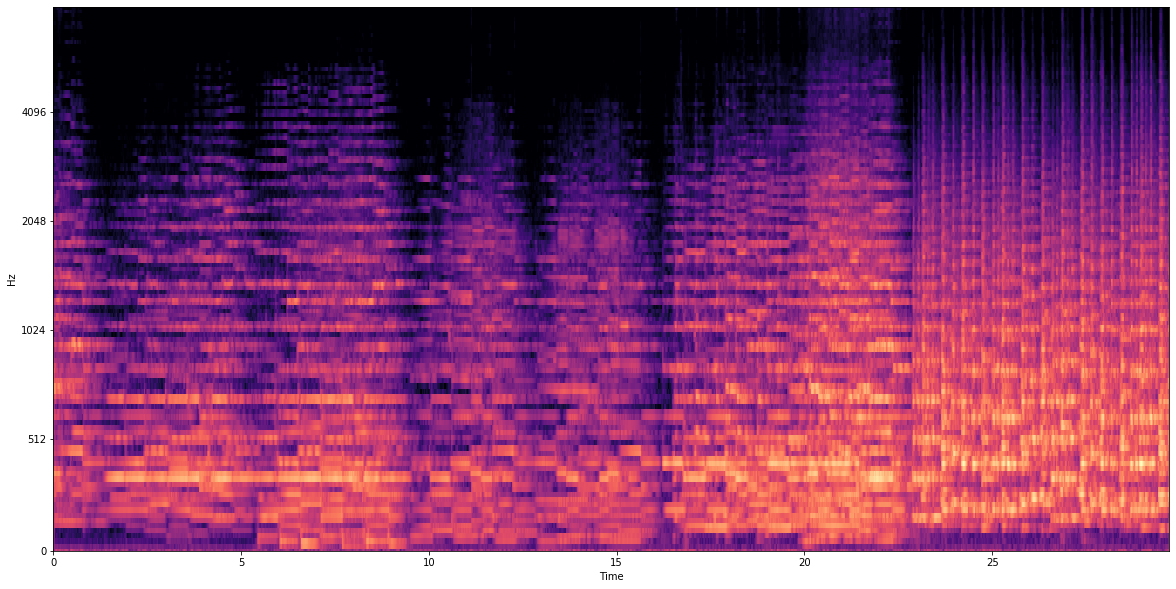

In [70]:
librosa.display.specshow(librosa.power_to_db(song_specs[405].T, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.show()

In [62]:
for i in range(len(genres)):
    if genres[i] == 4:
        print(i)
        break

400


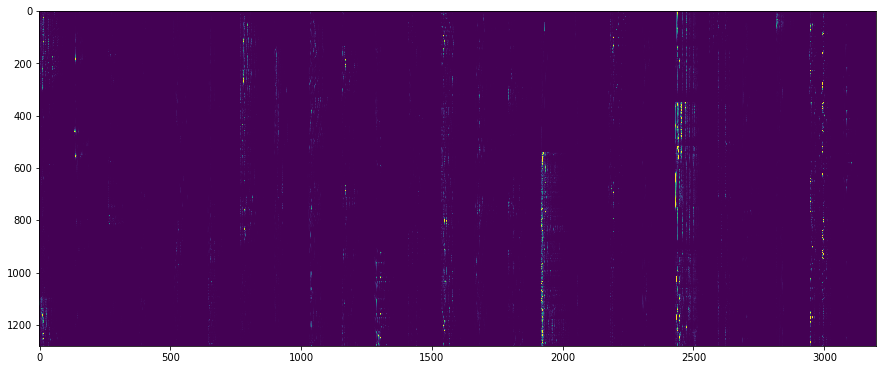

In [28]:
def show_spectogram(show_genre):
    show_genre = genre_to_idx[show_genre]
    specs = []
    for spec, genre in zip(song_specs, genres):
        if show_genre == genre:
            specs.append(spec)
            if len(specs) == 25:
                    break
    if not specs:
        return 'not found!'
    x = np.concatenate(specs, axis=1)
    x = (x - x.min()) / (x.max() - x.min())
    plt.figure(figsize = (15, 30))
    plt.imshow((x *20).clip(0, 1.0))
    

show_spectogram('classical')

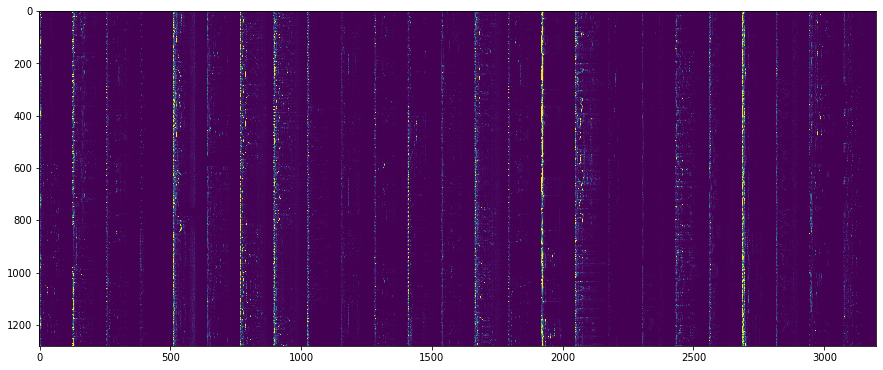

In [29]:
show_spectogram('metal')

In [89]:
def cnn_model(input_shape):
    inputs = Input(input_shape)
    x = inputs
    levels = 64
    for level in range(3):
        x = Conv1D(levels, 3, activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)
        levels *= 2
    # Global Layers
    x = GlobalMaxPooling1D()(x)
    for fc in range(2):
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
    labels = Dense(10, activation='softmax')(x)
    model = Model(inputs=[inputs], outputs=[labels])
    sgd = keras.optimizers.SGD(lr=0.0003, momentum=0.9, decay=1e-5, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model
model = cnn_model((128, 128))
model.summary()

W1012 00:19:17.111658 140235983771456 deprecation_wrapper.py:119] From /home/edgar/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1012 00:19:17.116382 140235983771456 deprecation_wrapper.py:119] From /home/edgar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 128, 128)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 126, 64)           24640     
_________________________________________________________________
batch_normalization_15 (Batc (None, 126, 64)           256       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 63, 64)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 61, 128)           24704     
_________________________________________________________________
batch_normalization_16 (Batc (None, 61, 128)           512       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 30, 128)           0         
__________

In [90]:
def split_10(x, y):
    s = x.shape
    s = (s[0] * 10, s[1] // 10, s[2])
    return x.reshape(s), np.repeat(y, 10, axis=0)

In [100]:
# genre lables to train
genres_one_hot = keras.utils.to_categorical(genres, num_classes=len(genre_to_idx))

In [104]:
x_train, x_test, y_train, y_test = train_test_split(np.array(song_specs), np.array(genres_one_hot), test_size=0.1, stratify=genres)

In [108]:
x_test, y_test = split_10(x_test, y_test)

In [109]:
x_train, y_train = split_10(x_train, y_train)

In [110]:
x_train.shape

(9000, 128, 128)

In [111]:
y_train.shape

(9000, 10)

In [112]:
history = model.fit(x_train, y_train,
batch_size=128,
epochs=100,
verbose=1,
validation_data=(x_test, y_test),)

W1012 00:33:57.818005 140235983771456 deprecation.py:323] From /home/edgar/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 14s 2ms/step - loss: 3.5538 - acc: 0.1392 - val_loss: 2.1368 - val_acc: 0.2660
Epoch 2/100
9000/9000 [==============================] - 9s 1ms/step - loss: 2.3946 - acc: 0.2066 - val_loss: 2.0333 - val_acc: 0.3270
Epoch 3/100
9000/9000 [==============================] - 10s 1ms/step - loss: 2.1863 - acc: 0.2336 - val_loss: 1.9947 - val_acc: 0.3270
Epoch 4/100
9000/9000 [==============================] - 10s 1ms/step - loss: 2.0839 - acc: 0.2583 - val_loss: 1.9527 - val_acc: 0.3420
Epoch 5/100
9000/9000 [==============================] - 10s 1ms/step - loss: 2.0356 - acc: 0.2722 - val_loss: 1.9265 - val_acc: 0.3510
Epoch 6/100
9000/9000 [==============================] - 10s 1ms/step - loss: 1.9842 - acc: 0.2881 - val_loss: 1.8891 - val_acc: 0.3600
Epoch 7/100
9000/9000 [==============================] - 10s 1ms/step - loss: 1.9571 - acc: 0.2909 - val_loss: 1.8595 - val_acc: 0.3810
E

9000/9000 [==============================] - 11s 1ms/step - loss: 1.0838 - acc: 0.6272 - val_loss: 1.2576 - val_acc: 0.5570
Epoch 61/100
9000/9000 [==============================] - 10s 1ms/step - loss: 1.0680 - acc: 0.6398 - val_loss: 1.2466 - val_acc: 0.5570
Epoch 62/100
9000/9000 [==============================] - 11s 1ms/step - loss: 1.0588 - acc: 0.6359 - val_loss: 1.2444 - val_acc: 0.5480
Epoch 63/100
9000/9000 [==============================] - 10s 1ms/step - loss: 1.0462 - acc: 0.6416 - val_loss: 1.2389 - val_acc: 0.5560
Epoch 64/100
9000/9000 [==============================] - 10s 1ms/step - loss: 1.0307 - acc: 0.6474 - val_loss: 1.2364 - val_acc: 0.5570
Epoch 65/100
9000/9000 [==============================] - 12s 1ms/step - loss: 1.0354 - acc: 0.6437 - val_loss: 1.2180 - val_acc: 0.5610
Epoch 66/100
9000/9000 [==============================] - 14s 2ms/step - loss: 1.0119 - acc: 0.6528 - val_loss: 1.2283 - val_acc: 0.5580
Epoch 67/100
9000/9000 [==============================

In [116]:
# save model here later

In [118]:

def unsplit(values):
    chunks = np.split(values, 100)
    return np.array([np.argmax(chunk) % 10 for chunk in chunks])

pred_values = model.predict(x_test)

In [119]:
predictions = unsplit(pred_values)

In [122]:
truth = unsplit(y_test)
accuracy = accuracy_score(predictions, truth)
print(accuracy)

0.66
